In [54]:
import os
from glob import glob
from tqdm import trange

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import Subset

from utils import calcuate, myenum, settings
from model import model

In [55]:
df_master = pd.read_csv(os.path.join(settings.PROCESSED_DIR, "master.csv"))
df_master.head()

,time,joint_root_pos.x,joint_root_pos.y,joint_root_pos.z,Hips_pos.x,Hips_pos.y,Hips_pos.z,Spine_pos.x,Spine_pos.y,Spine_pos.z,...,LowerLeg_R_rot.x,LowerLeg_R_rot.y,Foot_R_rot.z,Foot_R_rot.x,Foot_R_rot.y,Toes_R_rot.z,Toes_R_rot.x,Toes_R_rot.y,action,style
0,0.00000,0.0,0.0,0.0,0.84703,93.984,-452.225,1.23562,109.66571,-453.46808,...,-0.02441,15.4356,-4.90679,4.80721,-63.2857,0.17093,-0.19653,-18.4893,bow,active
1,0.03333,0.0,0.0,0.0,0.84703,93.984,-452.225,1.22332,109.64474,-453.71229,...,-0.11936,13.8441,-1.14206,6.04138,-61.9417,0.16444,-0.18884,-18.4154,bow,active
2,0.06667,0.0,0.0,0.0,0.84703,93.984,-452.225,1.11133,109.61934,-453.97961,...,-0.01741,13.3144,-0.58049,6.31064,-56.9017,0.08762,-0.09908,-17.5466,bow,active
3,0.10000,0.0,0.0,0.0,0.84703,93.984,-452.225,0.86777,109.59829,-454.17585,...,-0.01574,16.3196,-0.57617,6.00176,-58.9465,0.12953,-0.14772,-18.0187,bow,active
4,0.13333,0.0,0.0,0.0,0.84703,93.984,-452.225,0.79772,109.60352,-454.13297,...,-0.02627,16.6727,-0.30312,7.81876,-59.5834,0.10074,-0.11422,-17.6939,bow,active


<Axes: xlabel='style'>

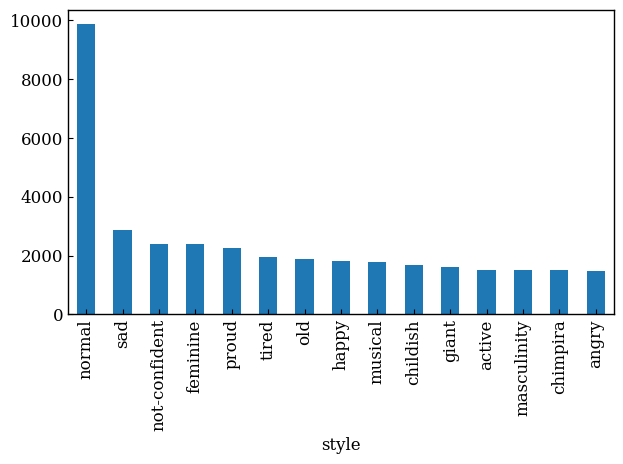

In [56]:
# 簡単な分析
df_master["style"].value_counts().plot.bar()

In [57]:
df_walk = df_master[df_master["action"] == "walk"]
# 前処理
df_walk = calcuate.calc_velocity_columns(df_walk, myenum.PositionColumns.get_all_positions())
df_walk_processed = df_walk.copy()
df_walk_processed[[*myenum.PositionColumns.get_all_positions(), *myenum.VelocityColumns.get_all_velocities()]] = \
    df_walk[
        [*myenum.PositionColumns.get_all_positions(), *myenum.VelocityColumns.get_all_velocities()]].apply(
        lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
df_walk_processed.head()

,time,joint_root_pos.x,joint_root_pos.y,joint_root_pos.z,Hips_pos.x,Hips_pos.y,Hips_pos.z,Spine_pos.x,Spine_pos.y,Spine_pos.z,...,UpperLeg_R.vz,LowerLeg_R.vx,LowerLeg_R.vy,LowerLeg_R.vz,Foot_R.vx,Foot_R.vy,Foot_R.vz,Toes_R.vx,Toes_R.vy,Toes_R.vz
29545,0.00000,0.769455,0.769455,0.769455,0.770837,0.922811,0.031548,0.771320,0.948476,0.030936,...,0.769455,0.769455,0.769455,0.769455,0.769455,0.769455,0.769455,0.769455,0.769455,0.769455
29546,0.03333,0.653415,0.653415,0.653415,0.654607,0.785741,0.016696,0.654391,0.807891,0.016258,...,0.644387,0.656228,0.628294,0.520399,0.654928,0.635241,0.492805,0.654457,0.635241,0.492651
29547,0.06667,0.622964,0.622964,0.622964,0.624105,0.749528,0.013977,0.623554,0.770710,0.013758,...,0.614695,0.627565,0.611934,0.514643,0.627724,0.621621,0.479602,0.627175,0.621620,0.479422
29548,0.10000,0.603089,0.603089,0.603089,0.604186,0.724719,0.017842,0.603594,0.745075,0.017866,...,0.595127,0.610412,0.601767,0.507542,0.609698,0.612785,0.470765,0.609176,0.612787,0.470596
29549,0.13333,0.593779,0.593779,0.593779,0.594851,0.712653,0.021794,0.594394,0.732549,0.021997,...,0.587616,0.599851,0.599539,0.504637,0.600045,0.613263,0.463092,0.599569,0.613265,0.462936


In [58]:
input_columns = [
    "Head_pos.x", "Head_pos.y", "Head_pos.z",
    "Hand_L_pos.x", "Hand_L_pos.y", "Hand_L_pos.z",
    "Hand_R_pos.x", "Hand_R_pos.y", "Hand_R_pos.z",
    "Head.vx", "Head.vy", "Head.vz",
    "Hand_L.vx", "Hand_L.vy", "Hand_L.vz",
    "Hand_R.vx", "Hand_R.vy", "Hand_R.vz",
]

output_columns = myenum.PositionColumns.get_all_positions()

x, y = df_walk_processed[input_columns], df_walk[output_columns]
x = torch.tensor(x.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
dataset = TensorDataset(x, y)

train_loss_history = []
valid_loss_history = []
epochs = 1000

kf = KFold(n_splits=4, shuffle=True, random_state=settings.seed)
cv_loss = []
train_loss_histories = []
valid_loss_histories = []

for _fold, (train_index, test_index) in enumerate(kf.split(df_walk_processed)):
    # モデル定義
    mlp = model.MLP(input_size=len(input_columns), hidden_size=128, num_classes=len(output_columns))

    # 損失関数と最適化アルゴリズムの定義
    criterion = nn.MSELoss()
    optimizer = optim.Adam(mlp.parameters(), lr=0.001)

    train_dataset = Subset(dataset, train_index)
    train_dataloader = DataLoader(train_dataset, 64, shuffle=True)
    valid_dataset = Subset(dataset, test_index)
    valid_dataloader = DataLoader(valid_dataset, 64, shuffle=False)
    train_loss_history = []
    valid_loss_history = []
    with trange(epochs) as t:
        for _ in t:
            t.set_description(f"fold {_fold}")
            train_loss = 0
            valid_loss = 0

            # 学習
            mlp.train()
            for inputs, labels in train_dataloader:
                outputs = mlp(inputs)
                loss = criterion(outputs, labels)
                # 勾配の初期化と逆伝播
                optimizer.zero_grad()
                loss.backward()
                # パラメータの更新
                optimizer.step()
                train_loss += loss.item()
            train_loss_history.append(train_loss / len(train_dataloader))

            # 推論
            mlp.eval()
            with torch.no_grad():
                for inputs, labels in valid_dataloader:
                    outputs = mlp(inputs)
                    loss = criterion(outputs, labels)
                    valid_loss += loss.item()
                valid_loss_history.append(valid_loss / len(valid_dataloader))
            t.set_postfix(train_loss=train_loss / len(train_dataloader), valid_loss=valid_loss / len(valid_dataloader))
            train_loss_history.append(train_loss / len(train_dataloader))
            valid_loss_history.append(valid_loss / len(valid_dataloader))
        cv_loss.append(valid_loss / len(valid_dataloader))
        train_loss_histories.append(train_loss_history)
        valid_loss_histories.append(valid_loss_history)

fold 3: 100%|██████████| 1000/1000 [11:03<00:00,  1.51it/s, train_loss=8.49, valid_loss=13.2]   


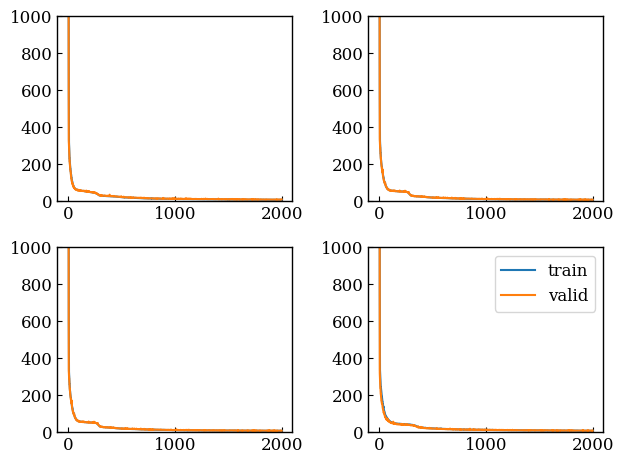

In [59]:
fig, ax = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        ax[i][j].plot(train_loss_histories[i + j], label="train")
        ax[i][j].plot(valid_loss_histories[i + j], label="valid")
        ax[i][j].set_ylim(0, 1000)
plt.legend()
# plt.savefig(os.path.join(settings.RESULT_DIR, "output", "cv4_each_loss_zoom.svg"))

9.467153882538831


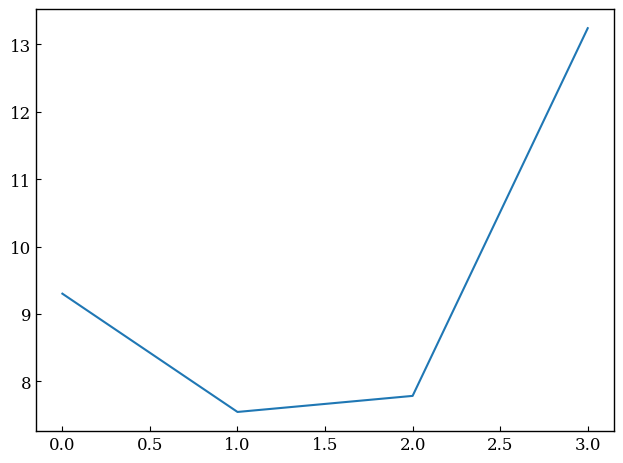

In [60]:
print(sum(cv_loss) / len(cv_loss))
plt.plot(cv_loss);
# plt.savefig(os.path.join(settings.RESULT_DIR, "output", "cv4_mean_1000epochs.svg"))

## Few-shot

In [61]:
from utils import animation

filename = "dataset-1_run_active_001_pos.csv"
df_label = pd.read_csv(os.path.join(settings.PROCESSED_DIR, "position", "action", "run", filename))
df_label = df_label.iloc[:20, :]

In [62]:
df_run = df_master[df_master["action"] == "run"]
# 前処理
df_run = calcuate.calc_velocity_columns(df_run, myenum.PositionColumns.get_all_positions())
df_run_processed = df_run.copy()
df_run_processed[myenum.PositionColumns.get_all_positions()] = df_walk[
    myenum.PositionColumns.get_all_positions()].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

In [63]:
input_columns = [
    "Head_pos.x", "Head_pos.y", "Head_pos.z",
    "Hand_L_pos.x", "Hand_L_pos.y", "Hand_L_pos.z",
    "Hand_R_pos.x", "Hand_R_pos.y", "Hand_R_pos.z",
    "Head.vx", "Head.vy", "Head.vz",
    "Hand_L.vx", "Hand_L.vy", "Hand_L.vz",
    "Hand_R.vx", "Hand_R.vy", "Hand_R.vz",
]

output_columns = myenum.PositionColumns.get_all_positions()

x, y = df_walk_processed[input_columns], df_walk[output_columns]
x = torch.tensor(x.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
dataset = TensorDataset(x, y)

train_size = int(len(dataset) * 0.7)
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset=dataset, lengths=[train_size, valid_size],
                                                             generator=torch.Generator().manual_seed(settings.seed))

train_dataloader = DataLoader(train_dataset, 64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, 64, shuffle=False)

# モデル定義
mlp = model.MLP(input_size=len(input_columns), hidden_size=128, num_classes=len(output_columns))

# 損失関数と最適化アルゴリズムの定義
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

epochs = 1500
train_loss_histories = []
valid_loss_histories = []
train_loss_history = []
valid_loss_history = []
with trange(epochs) as t:
    for _ in t:
        train_loss = 0
        valid_loss = 0

        # 学習
        mlp.train()
        for inputs, labels in train_dataloader:
            outputs = mlp(inputs)
            loss = criterion(outputs, labels)
            # 勾配の初期化と逆伝播
            optimizer.zero_grad()
            loss.backward()
            # パラメータの更新
            optimizer.step()
            train_loss += loss.item()

        # 推論
        mlp.eval()
        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                outputs = mlp(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
        t.set_postfix(train_loss=train_loss / len(train_dataloader), valid_loss=valid_loss / len(valid_dataloader))
        train_loss_history.append(train_loss / len(train_dataloader))
        valid_loss_history.append(valid_loss / len(valid_dataloader))
    train_loss_histories.append(train_loss_history)
    valid_loss_histories.append(valid_loss_history)

100%|██████████| 1500/1500 [06:31<00:00,  3.83it/s, train_loss=6.93, valid_loss=7.16]  


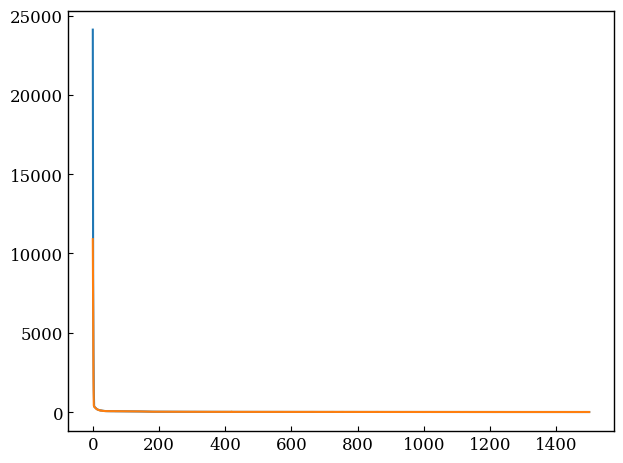

In [64]:
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
# plt.ylim(0, 100)

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


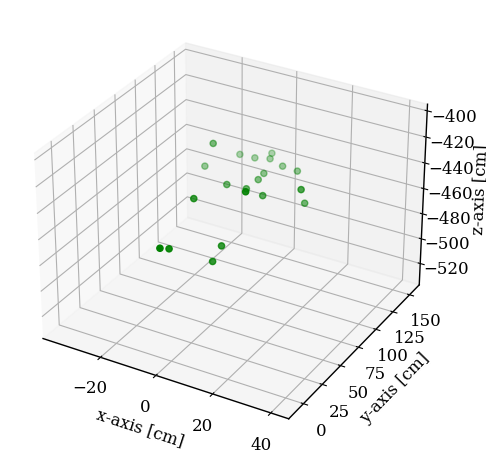

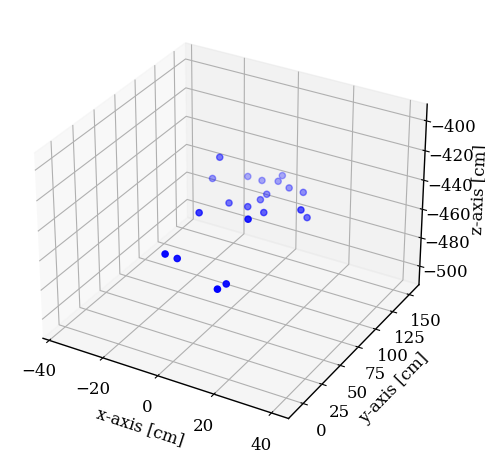

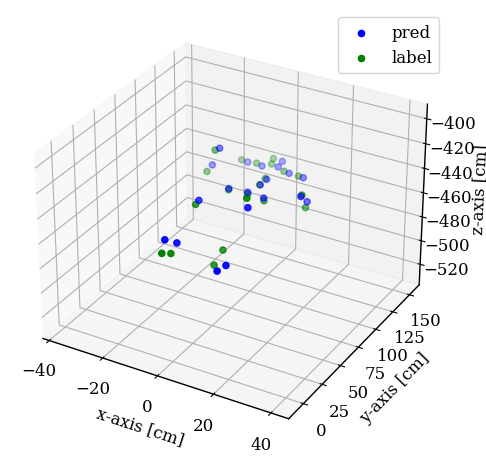

In [65]:
# 転移学習なしで予測した結果
filename = "dataset-1_run_active_001_pos.csv"
df_label = pd.read_csv(os.path.join(settings.PROCESSED_DIR, "position", "action", "run", filename))
df_label = calcuate.calc_velocity_columns(df_label, myenum.PositionColumns.get_all_positions())
df_label_processed = df_label.copy()
df_label_processed[[*myenum.PositionColumns.get_all_positions(), *myenum.VelocityColumns.get_all_velocities()]] = \
    df_label[
        [*myenum.PositionColumns.get_all_positions(), *myenum.VelocityColumns.get_all_velocities()]].apply(
        lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

x = torch.tensor(df_label_processed[input_columns].values, dtype=torch.float32)
pred = mlp(x)
pred = pred[:, 3:]

label = df_label[myenum.PositionColumns.get_all_positions()]
label = label.drop(["joint_root_pos.x", "joint_root_pos.y", "joint_root_pos.z"], axis=1)
output_name = "dataset-1_run_active_001_pos_no_transfer.csv"
animation.create_gif(label, output_name)
animation.create_gif(pred, output_name)
animation.create_git_combine(label, pred, output_name)

In [66]:
loss = nn.MSELoss()
label = torch.tensor(label.values, dtype=torch.float32)
loss(pred, label)

tensor(87.0096, grad_fn=<MseLossBackward0>)

### 転移学習

In [67]:
# 損失関数と最適化アルゴリズムの定義
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.0001)

x, y = df_walk_processed[input_columns], df_walk[output_columns]
x = torch.tensor(x.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
dataset = TensorDataset(x, y)
train_dataloader = DataLoader(dataset, 64, shuffle=True)

train_loss_history = []
epochs = 100
with trange(epochs) as t:
    for _ in t:
        train_loss = 0

        # 学習
        mlp.train()
        for inputs, labels in train_dataloader:
            outputs = mlp(inputs)
            loss = criterion(outputs, labels)
            # 勾配の初期化と逆伝播
            optimizer.zero_grad()
            loss.backward()
            # パラメータの更新
            optimizer.step()
            train_loss += loss.item()
        train_loss_history.append(train_loss / len(train_dataloader))
        t.set_postfix(train_loss=train_loss / len(train_dataloader))

100%|██████████| 100/100 [00:11<00:00,  8.64it/s, train_loss=6.21]


## 結果の出力

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


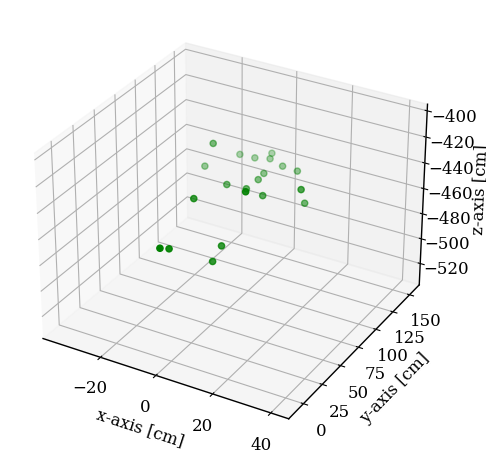

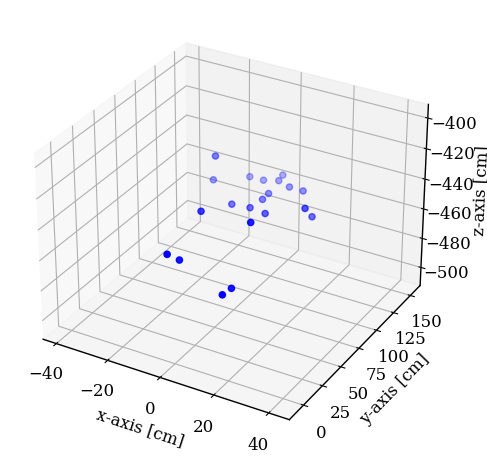

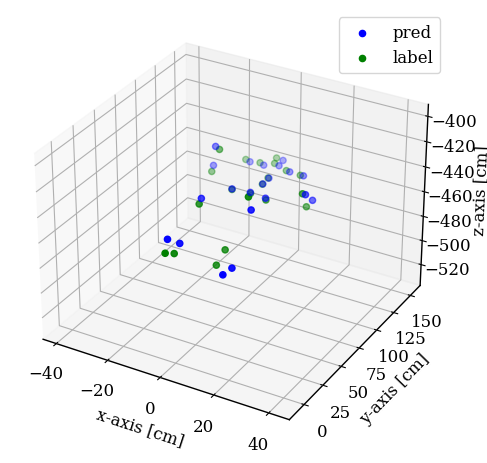

In [68]:
filename = "dataset-1_run_active_001_pos.csv"
df_label = pd.read_csv(os.path.join(settings.PROCESSED_DIR, "position", "action", "run", filename))
df_label = calcuate.calc_velocity_columns(df_label, myenum.PositionColumns.get_all_positions())
df_label_processed = df_label.copy()
df_label_processed[[*myenum.PositionColumns.get_all_positions(), *myenum.VelocityColumns.get_all_velocities()]] = \
    df_label[
        [*myenum.PositionColumns.get_all_positions(), *myenum.VelocityColumns.get_all_velocities()]].apply(
        lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

x = torch.tensor(df_label_processed[input_columns].values, dtype=torch.float32)
pred = mlp(x)
pred = pred[:, 3:]

label = df_label[myenum.PositionColumns.get_all_positions()]
label = label.drop(["joint_root_pos.x", "joint_root_pos.y", "joint_root_pos.z"], axis=1)
animation.create_gif(label, filename)
animation.create_gif(pred, filename)
animation.create_git_combine(label, pred, filename)

In [69]:
loss = nn.MSELoss()
label = torch.tensor(label.values, dtype=torch.float32)
loss(pred, label)

tensor(85.7970, grad_fn=<MseLossBackward0>)